이 자료는 위키독스 딥 러닝을 이용한 자연어 처리 입문의 양방향 LSTM을 이용한 품사 태깅 학습 자료입니다.  

링크 : https://wikidocs.net/33532

# 12-02 양방향 LSTM를 이용한 품사 태깅(Part-of-speech Tagging using Bi-LSTM)
---

품사 태깅에 대해서는 이미 텍스트 전처리 챕터에서 토큰화와 함께 언급한 바 있습니다. 그 당시에는 NLTK와 KoNLPy를 이용해서 품사 태깅을 수행하였지만, 여기서는 직접 양방향 LSTM을 이용한 품사 태깅을 수행하는 모델을 만들어봅니다.

## 1.품사 태깅 데이터에 대한 이해와 전처리
---
양방향 LSTM을 이용해서 품사 태깅을 하는 모델을 만들어보겠습니다.

In [2]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

NLTK를 이용하면 영어 코퍼스에 토큰화와 품사 태깅 전처리를 진행한 문장 데이터를 받아올 수 있습니다. 해당 데이터를 훈련시켜 품사 태깅을 수행하는 모델을 만들어보겠습니다. 전체 문장 샘플의 개수를 확인합니다.

In [3]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\jeong\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [4]:
# 토큰화에 품사 태깅이 된 데이터 받아오기
tagged_sentences = nltk.corpus.treebank.tagged_sents() # 토큰화에 품사 태깅이 된 데이터 받아오기
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences)) # 문장 샘플의 개수 출력

품사 태깅이 된 문장 개수:  3914


In [5]:
tagged_sentences

[[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')], [('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')], ...]

첫번째 샘플만 출력해보겠습니다.

In [6]:
print(tagged_sentences[0]) # 첫번째 문장 샘플 출력

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


품사 태깅 전처리가 수행된 첫번째 문장이 출력된 것을 볼 수 있습니다. 이러한 문장 샘플이 총 3,914개가 있습니다. 그런데 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 품사 태깅 정보에 해당되는 부분을 분리시켜야 합니다. 즉, [('Pierre', 'NNP'), ('Vinken', 'NNP')]와 같은 문장 샘플이 있다면 Pierre과 Vinken을 같이 저장하고, NNP와 NNP를 같이 저장할 필요가 있습니다.

이런 경우 파이썬 함수 중에서 zip()함수가 유용한 역할을 합니다. zip()함수는 동일한 개수를 가지는 시퀀스 자료형에서 동일한 순서에 등장하는 원소들끼리 묶어주는 역할을 합니다.

In [7]:
sentences, pos_tags =[], [] 
for tagged_sentence in tagged_sentences: # 3,914개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어는 sentence에 품사 태깅 정보는 tags에 저장한다.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    pos_tags.append(list(tag_info)) # 각 샘플에서 품사 태깅 정보만 저장한다.

각 문장 샘플에 대해서 단어는 sentences에 태깅 정보는 pos_tags에 저장하였습니다. 첫번째 문장 샘플을 출력해보겠습니다.

In [8]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


첫번째 샘플에 대해서 단어에 대해서 sentences[0]에, 품사에 대해서만 pos_tags[0]에 저장된 것을 볼 수 있습니다. 뒤에서 보겠지만, sentences는 예측을 위한 X에 해당되며 pos_tags는 예측 대상인 y에 해당됩니다. 임의로 8번 인덱스 샘플에 대해서도 확인해보겠습니다.

In [9]:
print(sentences[8])
print(pos_tags[8])

['We', "'re", 'talking', 'about', 'years', 'ago', 'before', 'anyone', 'heard', 'of', 'asbestos', 'having', 'any', 'questionable', 'properties', '.']
['PRP', 'VBP', 'VBG', 'IN', 'NNS', 'IN', 'IN', 'NN', 'VBD', 'IN', 'NN', 'VBG', 'DT', 'JJ', 'NNS', '.']


단어에 대해서만 sentences[8]에, 또한 품사에 대해서만 pos_tags[8]에 저장된 것을 확인할 수 있습니다. 또한 첫번째 샘플과 길이가 다른 것을 볼 수 있습니다. 사실 3,914개의 문장 샘플의 길이는 전부 제각각입니다. 전체 데이터의 길이 분포를 확인해봅시다.

샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


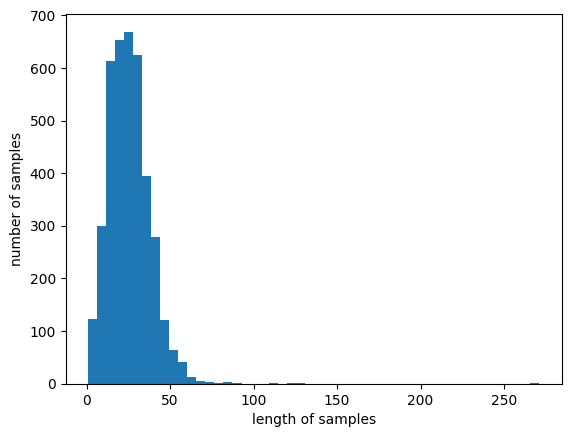

In [10]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프는 대부분의 샘플의 길이가 150 이내며 대부분 0~50의 길이를 가지는 것을 보여줍니다. 이제 케라스 토크나이저를 통해서 정수 인코딩을 진행합니다. 우선 케라스 토크나이저를 다음과 같이 함수로 구현합니다.

In [11]:
def tokenize(samples):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer

문장 데이터에 대해서는 src_tokenizer를, 레이블에 해당되는 품사 태깅 정보에 대해서는 tar_tokenizer를 사용합니다.

In [12]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

단어 집합과 품사 태깅 정보 집합의 크기를 확인해보겠습니다.

In [13]:
vocab_size = len(src_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))

단어 집합의 크기 : 11388


In [14]:
tag_size = len(tar_tokenizer.word_index) + 1
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

태깅 정보 집합의 크기 : 47


정수 인코딩을 수행합니다.

In [15]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

문장 데이터에 대해서 정수 인코딩이 수행된 결과는 X_train, 품사 태깅 데이터에 대해서 정수 인코딩이 수행된 결과는 y_train에 저장되었습니다. 정수 인코딩이 되었는지 확인을 위해 임의로 2번 인덱스 샘플을 출력해보겠습니다.

In [16]:
print(X_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]


In [17]:
print(y_train[:2])

[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


앞서 본 그래프에 따르면, 대부분의 샘플은 길이가 150 이내입니다. X에 해당되는 데이터 X_train의 샘플들과 y에 해당되는 데이터 y_train 샘플들의 모든 길이를 임의로 150정도로 맞추어 보겠습니다. 케라스의 pad_sequences()를 사용합니다.

In [18]:
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

모든 샘플의 길이가 150이 되었습니다. 훈련 데이터와 테스트 데이터를 8:2의 비율로 분리합니다.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

각 데이터에 대한 크기(shape)를 확인해보겠습니다.

In [20]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150)


# 2.양방향 LSTM(Bi-directional LSTM)으로 POS Tagger 만들기
---
임베딩 벡터의 차원과 LSTM의 은닉 상태의 차원은 128로 지정했습니다. 다대다 문제이므로 LSTM의 return_sequences의 값은 True로 지정하였으며, 양방향 사용을 위해 LSTM을 Bidirectional()로 감싸주었습니다. validation_data로는 테스트 데이터를 기재하여 학습 중간에 테스트 데이터의 정확도를 확인하였습니다.

레이블에 대해서 원-핫 인코딩을 하고 손실 함수를 categorical_crossentropy를 사용할 수도 있겠지만, 만약 레이블에 원-핫 인코딩을 하지 않고 학습을 진행하고자 한다면 손실 함수를 categorical_crossentropy 대신 sparse_categorical_crossentropy를 선택합니다. 여기서는 후자의 방법을 택합니다.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
###############################################
tf.config.run_functions_eagerly(True)   # 2024.08 OperatorNotAllowedInGraphError: Exception encountered when calling TimeDistributed.call().
###############################################

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(0.001),metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
y_train

array([[ 4,  1, 17, ...,  0,  0,  0],
       [12,  8,  3, ...,  0,  0,  0],
       [ 4, 17,  4, ...,  0,  0,  0],
       ...,
       [ 3,  8,  4, ...,  0,  0,  0],
       [ 1,  6, 20, ...,  0,  0,  0],
       [25,  4,  3, ...,  0,  0,  0]])

In [24]:
%%time
## 2024.08 CPU(Notebook)
# Epoch 20/20
# 25/25 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.1726 - loss: 0.0315 - val_accuracy: 0.1601 - val_loss: 0.2170
# CPU times: total: 12min 46s
# Wall time: 35min 37s
# history = model.fit(X_train, y_train, batch_size=128, epochs=7, validation_data=(X_test, y_test))
history = model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20


c:\Users\jeong\anaconda3-1\envs\py310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.1545 - loss: 3.5932 - val_accuracy: 0.0415 - val_loss: 2.7918
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.0580 - loss: 2.5961 - val_accuracy: 0.0828 - val_loss: 2.0087
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.0877 - loss: 1.8449 - val_accuracy: 0.1087 - val_loss: 1.3628
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.1212 - loss: 1.2053 - val_accuracy: 0.1398 - val_loss: 0.8329
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.1462 - loss: 0.7106 - val_accuracy: 0.1499 - val_loss: 0.5307
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.1576 - loss: 0.4179 - val_accuracy: 0.1547 - val_loss: 0.3881
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.1632 - loss: 0.2709 - val_accuracy: 0.1569 - val_loss: 0.3111
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.1672 - loss: 0.1808 - val_accuracy: 0.1581 - val_loss: 0.2

<Axes: >

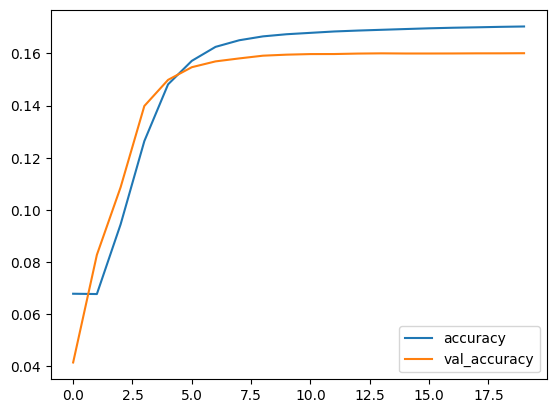

In [25]:
import pandas as pd
df_history = pd.DataFrame(history.history)
df_history[['accuracy', 'val_accuracy']].plot()

In [ ]:
df_history[['loss', 'val_loss']].plot()

총 7번의 에포크를 마치고나서 테스트 데이터에 대한 정확도를 측정합니다.

In [26]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

c:\Users\jeong\anaconda3-1\envs\py310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.1604 - loss: 0.2179

 테스트 정확도: 0.1601


실제로 맞추고 있는지를 특정 테스트 샘플(10번 인덱스)을 통해 확인해보겠습니다. 정수로부터 단어와 품사 태깅 정보를 리턴하는 index_to_word와 index_to_tag를 만들고 이를 이용하여 실제값과 예측값을 출력합니다.

In [27]:
index_to_word = src_tokenizer.index_word
index_to_tag = tar_tokenizer.index_word

i = 10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], y_test[i], y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_tag[tag].upper(), index_to_tag[pred].upper()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .
